# Example AXIO to STPT projection

Notes:

* Reprojection values are for the x16 downsampled images
* Reprojection is channel and z independent

Changelog:

* Initial version (eglez: 20221130)

In [76]:
# Requires SimpleITK
import math
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.stats import median_abs_deviation

In [77]:
# Location of datasets
stpt_name = "/storage/processed/stpt/20220208_MPR_NSG_GFP_4T1_TdTOM_inflated_lung_Day21_200x15um"
axio_name = "/storage/processed/axio/20220208_MPR_NSG_GFP_4T1_TdTOM_inflated_lung_Day21_200x15um_Axio"

In [78]:
# Parameters from the output CSV file

(
    axio,
    stpt,
    scale,
    flip,
    angle,
    x_axio,
    y_axio,
    h_axio,
    w_axio,
    x_stpt,
    y_stpt,
    h_stpt,
    w_stpt,
    x_centre,
    y_centre,
    x_translation,
    y_translation,
    m00,
    m10,
    m01,
    m11,
) = (
    "S009",
    "S103",
    1.1851827055468787,
    2,
    35.39401984965746,
    599,
    305,
    1139,
    701,
    220,
    181,
    1101,
    1135,
    599.4515031749248,
    571.3475542426611,
    -326.17813239963937,
    -36.583131895953414,
    0.690909443405805,
    0.47972006216265733,
    -0.48361932538129415,
    0.6882155507834069,
)

In [88]:
(
    axio,
    stpt,
    scale,
    flip,
    angle,
    x_axio,
    y_axio,
    h_axio,
    w_axio,
    x_stpt,
    y_stpt,
    h_stpt,
    w_stpt,
    x_centre,
    y_centre,
    x_translation,
    y_translation,
    m00,
    m10,
    m01,
    m11,
) = (
    "S009",
    "S105",
    1.1808646451447191,
    2,
    35.49641683549631,
    597,
    304,
    1141,
    705,
    219,
    179,
    1106,
    1138,
    600.9048898279982,
    573.4061469605386,
    -326.4032873804773,
    -40.41057157652168,
    0.6930010586187781,
    0.48393479081080654,
    -0.4769919464956778,
    0.6948270314358184,
)

In [89]:
# Read data (x16 downsampled image)
ds_axio = xr.open_zarr(axio_name + "/mos", group="l.16")
ds_stpt = xr.open_zarr(stpt_name + "/mos", group="l.16")

In [90]:
# Pick z and channel
im_axio = ds_axio[axio].sel(z=0, channel=2).data
im_stpt = ds_stpt[stpt].sel(z=0, channel=2).data

In [91]:
# flip correction
if flip == 1:
    im_axio = im_axio[::-1,:]
elif flip==2:
    im_axio = im_axio[:,::-1]
    
flip = 0
    
# Pick the common footprint 
# This will need to be modified if not using x16 downsample
im_axio_fp = im_axio[y_axio:y_axio+h_axio,x_axio:x_axio+w_axio]
im_stpt_fp = im_stpt[y_stpt:y_stpt+h_stpt,x_stpt:x_stpt+w_stpt]

In [92]:
# Transformation matrix
# centre and translation will need to be modified if not using x16 downsample
matrix = np.array([m00, m10, m01, m11])
centre = [x_centre, y_centre]
translation=[x_translation, y_translation]

at = sitk.AffineTransform(matrix, translation, centre)

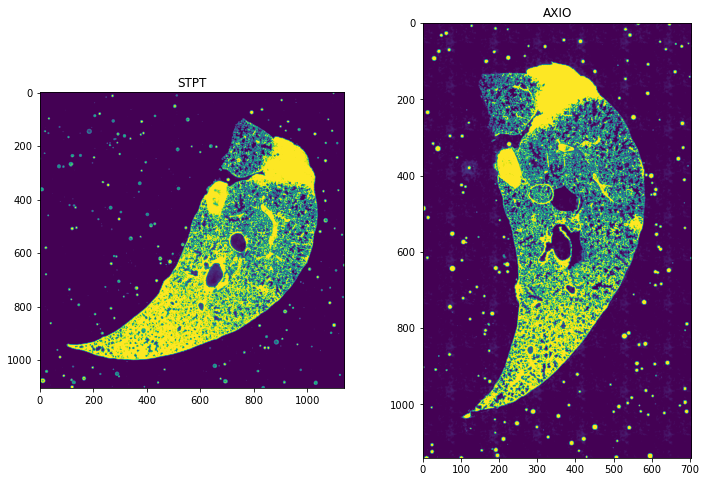

In [93]:
im1 = np.array(im_stpt_fp)
im2 = np.array(im_axio_fp)

indx = im2.ravel() > 0
z1, z2 = np.median(im2.ravel()[indx]), median_abs_deviation(im2.ravel()[indx])
im2 = im2.clip(z1, z1 + 20 * z2)

indx = im1.ravel() > 0
z1, z2 = np.median(im1.ravel()[indx]), median_abs_deviation(im1.ravel()[indx])
im1 = im1.clip(z1, z1 + 20 * z2)
        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
ax[0].imshow(im1)
ax[0].set_title('STPT')
ax[1].imshow(im2)
ax[1].set_title('AXIO')
_;

In [94]:
fixed = sitk.GetImageFromArray(im1)
moving = sitk.GetImageFromArray(im2)
outTx = at

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)
array = sitk.GetArrayFromImage(out)

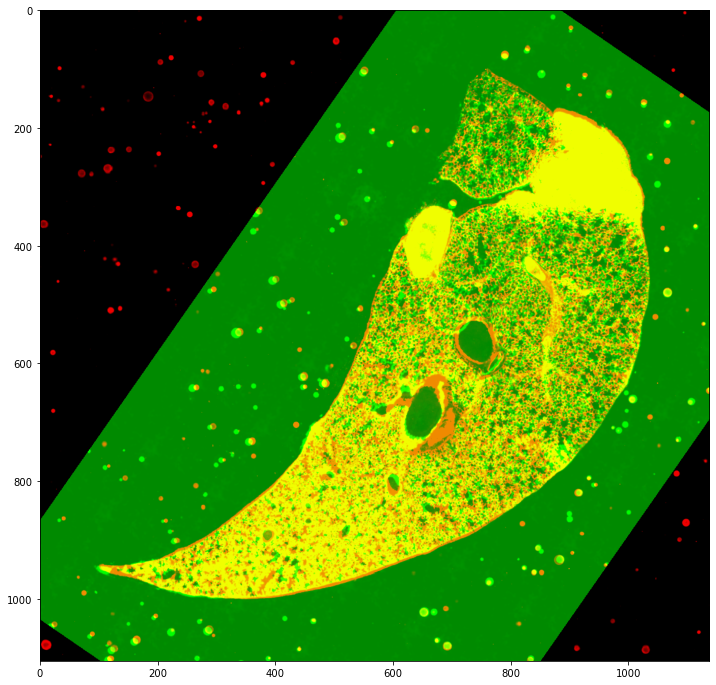

In [95]:
img = np.zeros((im1.shape[0], im1.shape[1], 3))
img[..., 0] = (im1 - im1.min()) / im1.max()
img[..., 1] = (array - array.min()) / array.max()

plt.figure(figsize=(12,12))
plt.imshow(img)
_;